In [47]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# some previously collected data
portfoliodata = pd.read_pickle("C:\\Users\\fuem\\Dropbox (Bank of Canada)\\DataEJN\\CURRENCY_forGitHub\\CleanData\\PortfolioData_interestrates_wICIO.pkl")
portfoliodata = portfoliodata[['iso3', 'Date', 'year', 'gdp', 'spot', 'fwd1', 'policyrate', 'shortterm']]

# country codes
imf_codes = pd.read_csv("C:\\Users\\fuem\\Dropbox (Bank of Canada)\\DataEJN\\CURRENCY_forGitHub\\RawData\\Country_iso_codes.csv")

In [4]:
# iip data (actually has quarterly data and the coverage is significantly better)
iip = pd.read_csv('data/BOP_11-08-2023 15-53-24-14_timeSeries.csv', low_memory=False)

'''
some of the indicators: 
IA_BP6_USD: Assets, Total, US Dollars
IL_BP6_USD: Liabilities, Total, US Dollars
'''

# add iso3 codes in order to merge data
iso3_map = imf_codes.set_index('IMF').to_dict()['iso3']
iip['iso3']= iip['Country Code'].map(iso3_map)

# remove unnecessary rows/columns
iip = iip[iip['Attribute'] == 'Value']
iip = iip.drop(['Country Name', 'Country Code', 'Attribute', 'Unnamed: 139'], axis=1)

# Specify the columns to keep as identifiers
id_vars = ['Indicator Name', 'Indicator Code', 'iso3']

# Use the melt function to convert the DataFrame to long format
iip_long = pd.melt(iip, id_vars=id_vars, var_name='date', value_name='value')

# convert to datetime
iip_long['date'] = pd.to_datetime(iip_long['date'])
# end-of-month values
iip_long['date'] = iip_long['date'] + pd.offsets.MonthEnd(0)

# convert to numeric
iip_long['value'] = pd.to_numeric(iip_long['value'])

In [36]:
iip_long[(iip_long['Indicator Code'] == 'IA_BP6_USD') & (iip_long['value'].notnull())].dtypes

Indicator Name            object
Indicator Code            object
iso3                      object
date              datetime64[ns]
value                    float64
dtype: object

a.	Using either the CPIS data (aggregated to the country level) or the International Investment Position data, can you see if the countries with the largest asset positions are those with the lowest interest rates (i.e. US, Japan, Switzerland, Germany)? Can you see what Australia and New Zealand’s Asset positions look like – are they different to these countries materially? Do you see the same patterns if we divide by GDP? Are the patters strongest for gross assets? Net assets? Equity only? Bonds only?

In [48]:
# find the asset positions series, get value by country (sum or average?), 
# take portfoliodata short term interest rates, get value by country (average)
# merge by country

interestrates = portfoliodata[(portfoliodata['Date'] >= dt.datetime(1990,1,31)) & (portfoliodata['Date'] <= dt.datetime(2023,4,30))][['iso3', 'shortterm']].groupby('iso3').mean()

assetsgross = iip_long[(iip_long['Indicator Code'] == 'IA_BP6_USD') & (iip_long['value'].notnull())][['iso3', 'value']].groupby('iso3').sum(numeric_only=False)

item_a = pd.merge(left=interestrates, right=assetsgross, how='inner', on='iso3').dropna()

item_a.rename(columns={'value': 'iip_assetsgross'}, inplace=True)

In [52]:
item_a

,shortterm,iip_assetsgross
iso3,,
AGO,14.559048,2.383909e+12
ALB,4.245172,3.337735e+11
ARM,9.343905,3.310843e+11
AUS,4.859687,1.271500e+14
AZE,13.210197,5.304857e+11
BEL,2.711953,1.809741e+14
BGR,2.925427,3.330614e+12
BHR,1.594737,4.106274e+12
CAN,3.196250,2.650693e+14


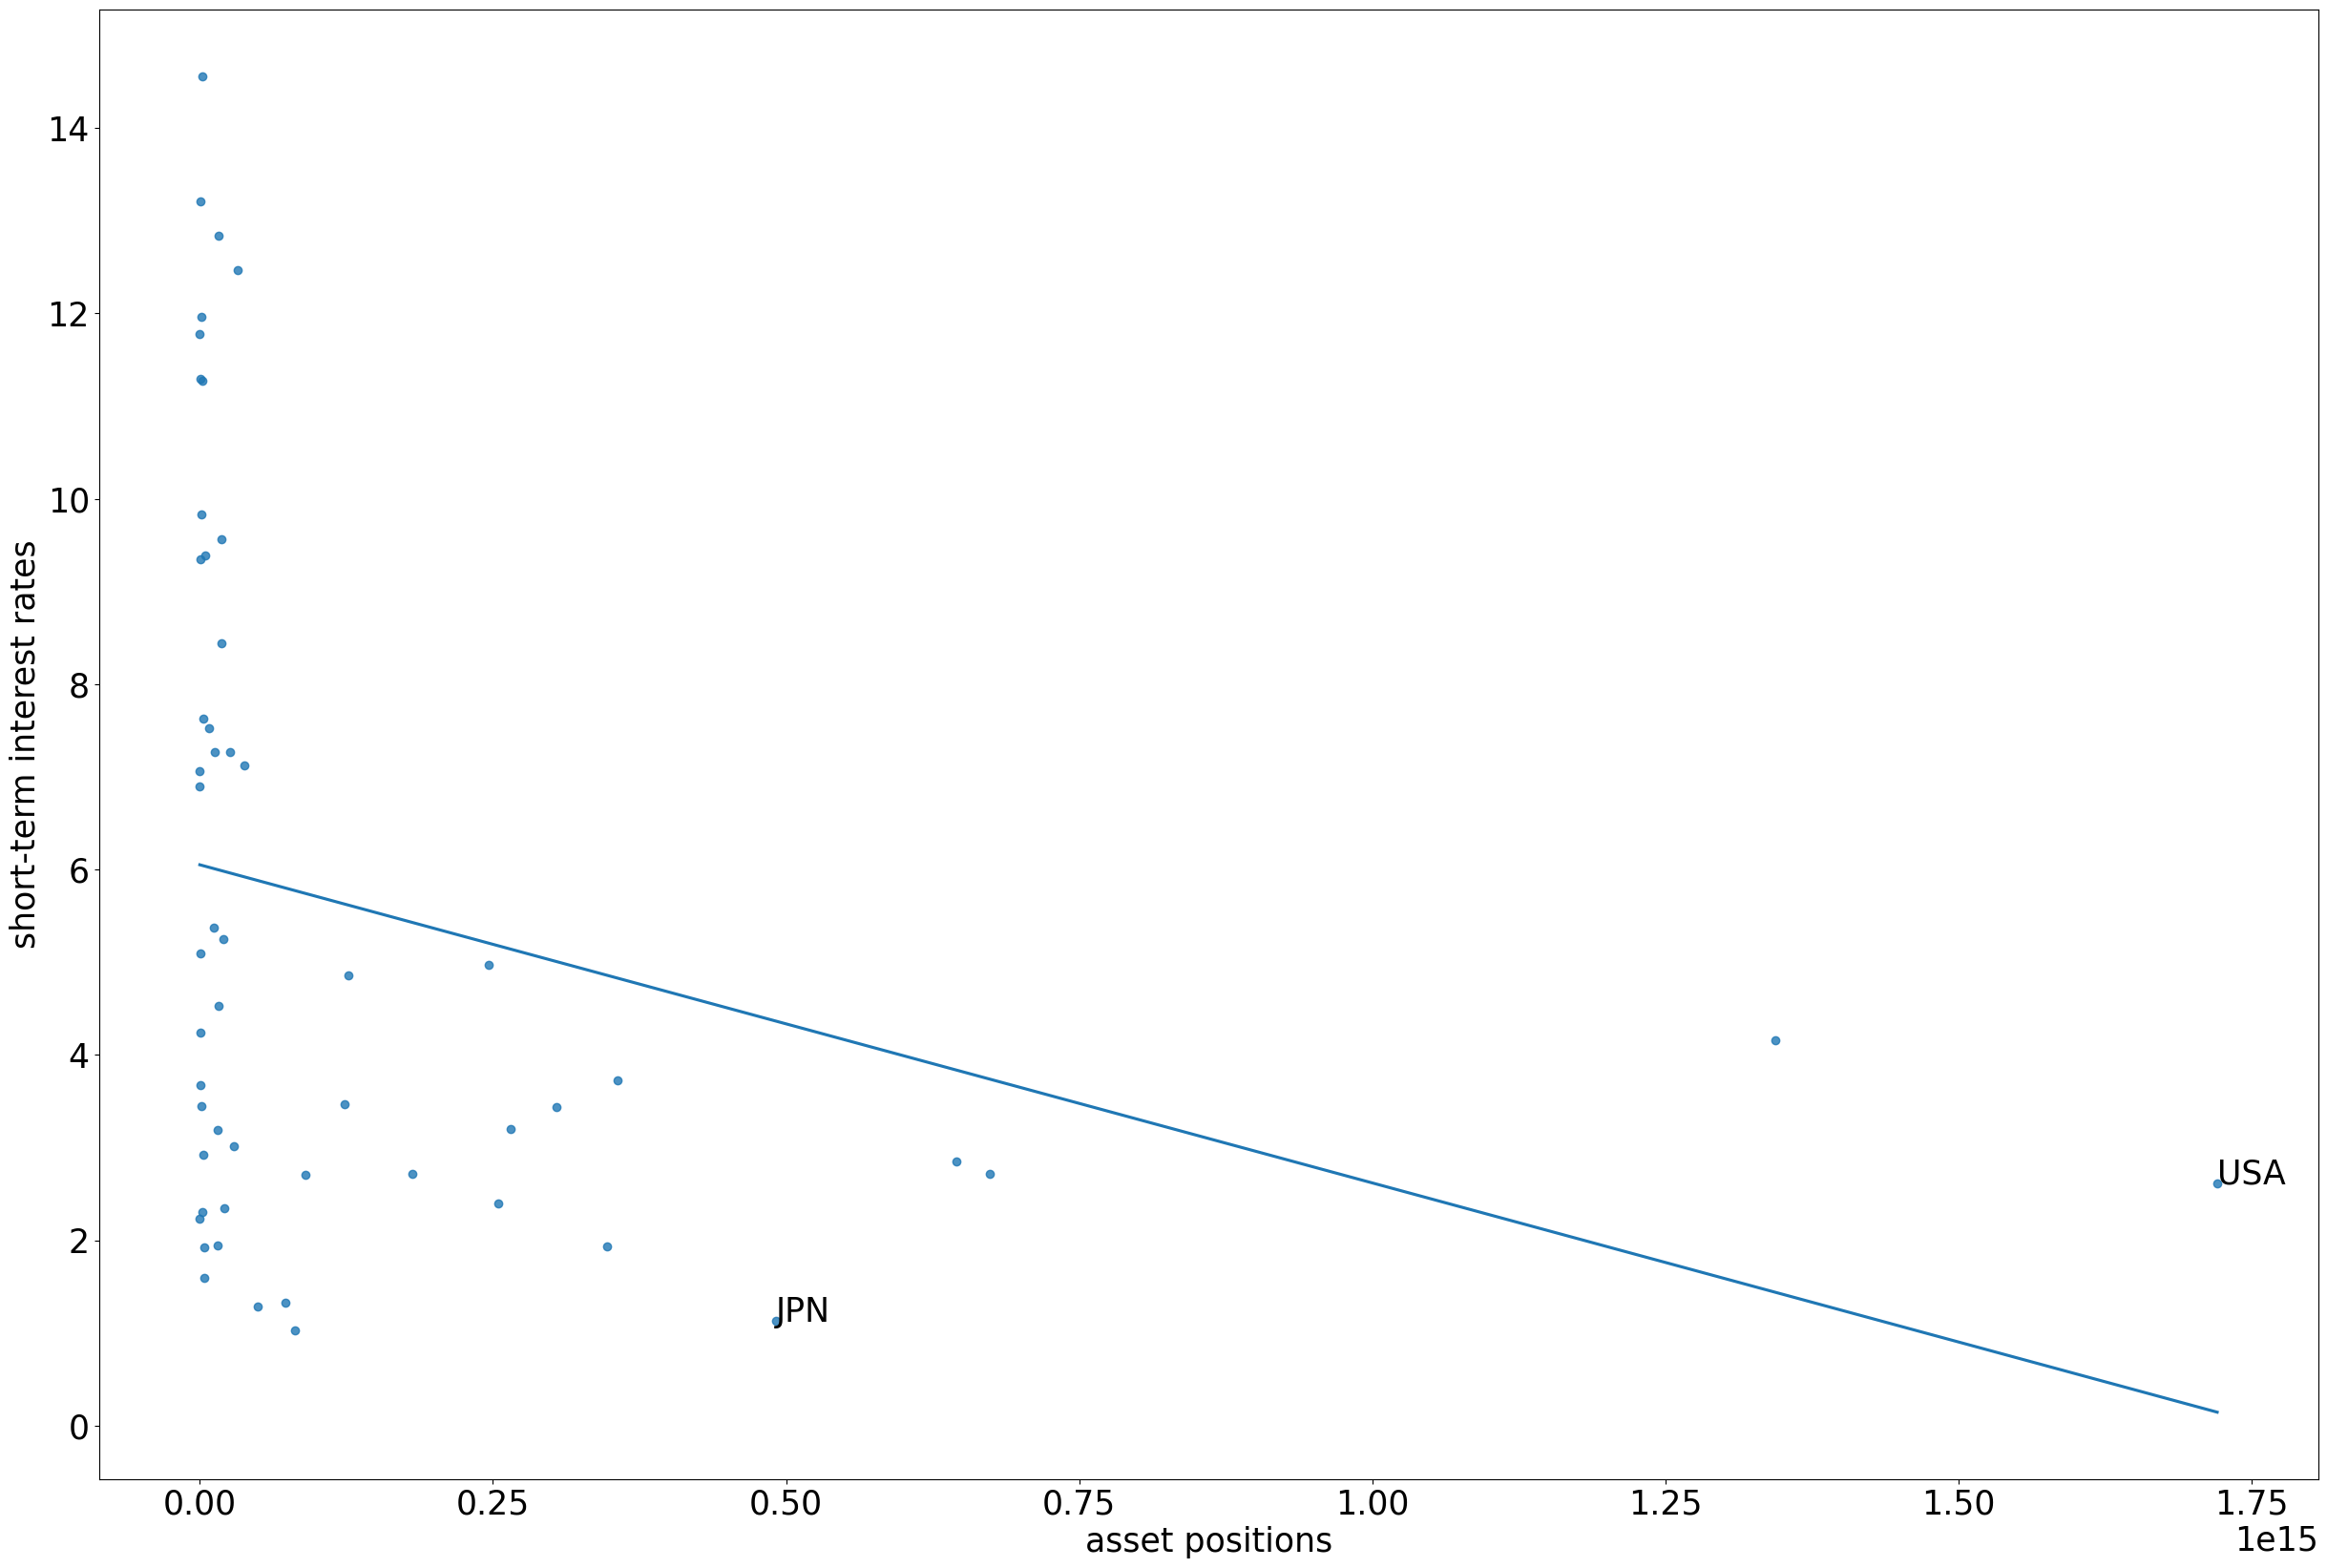

In [51]:
# small scatterplot

plt.rcParams.update({'font.size': 25})

# open figure + axis
fig = plt.subplots(figsize=(30,20))
# plot
ax = sns.regplot(x=item_a['iip_assetsgross'],y=item_a['shortterm'],ci=None)
# set labels
ax.set_xlabel('asset positions')
ax.set_ylabel('short-term interest rates')

# annotate points in axis
for idx, row in item_a.iterrows():
    if idx in ['USA', 'JPN', 'DEU']:
        ax.annotate(idx, (row['iip_assetsgross'], row['shortterm']) )